# Problem Set 6

In [1]:
# Loading Packages
using Parameters, LinearAlgebra, Plots, Interpolations, Optim

# Loadifng Programs 
include("../JuliaCode/hopenhayn_rogerson.jl")

# Set plot theme
theme(:juno) # Change to vibrant for writeup
default(fontfamily="Computer Modern", framestyle=:box) # LaTex-style

## Part 1: No Random Disturbances

### Enviroment 
* Unit measure of identical households and a continuum of firms (mass not necessarily $1$) which produce a homogeneous final product that sells at price $p_t$
* Production function $q_t=s_tn_t^\theta$
* $s_t\in \mathbb{R}_+$ is a productivity shock that follows a first order Markov process with $F(s'=s_{t+1}|s=s_t)$.
* Each period that the firm stays in the market, it bears a fixed cost $c_f$ valued at $p_t$.
* Potential entrants decide whether to pay entry cost $c_e$.
* Entrants productivity shocks are drawn from a distribution $\nu(s_t)$ that is iid acrros all firms.


In [95]:
# Initialize the model's parameters and results struct
prim, res = Initialize();

# Create the structure for experiments 1 and 2 with random disturbances
_, res_1 = Initialize();
_, res_2 = Initialize();
_, res_3 = Initialize();


### Equilibrium

**Definition.** A stationary equilibrium consists of an output price $p^{*} \geq 0$, a mass of entrants $M^{*} \geq 0$, and a measure of incumbents $\mu *$ such that 
1. $L^{d}\left(\mu^{*}, M^{*}, p^{*}\right)=L^{s}\left(p^{*}, \Pi\left(\mu^{*}, M^{*}, p^{*}\right)+R\left(\mu^{*}, M^{*}, p^{*}\right)\right)$, 
2. $T\left(\mu^{*}, M^{*} ; p^{*}\right)=\mu^{*}$
3.  $W^{e}\left(p^{*}\right) \leq p^{*} c_{e}$ with equality if $M *>0$

#### Policy Funcitons and Prices

There are two decisions of an incumbent firm: optimal employment $n^{*}=N^{d}\left(s_{t} ; p\right)$ and optimal exit next period $x^{\prime}=X\left(s_{t} ; p\right) \in\{0,1\}$ $x=1$ means exit.

We can obtain $n^{*}$ solving the firm's profit maximization problem:
$$
\pi(s ; p)=\max _{n \geq 0} p s n^{\theta}-n-p c_{f}
$$

First Order Conditions imply:
$$
\theta p s n^{\theta - 1} - 1 = 0 \qquad \implies \qquad \boxed{n^* = (\theta p s)^{1/(1-\theta)}}
$$

We can optain the optimal exit next period $x^{\prime} by solving the following dynamic programming problem

$$
W(s ; p)=\max _{x^{\prime} \in\{0,1\}}\left\{\pi(s ; p)+\beta\left(1-x^{\prime}\right) \int_{s^{\prime}} W\left(s^{\prime} ; p\right) d F\left(d s^{\prime} \mid s\right)\right\}
$$

The following is `Julia` function returns the Bellman operator for the firm's profit maximization problem.

In [96]:
# Bellman operator for W
function W(prim::Primitives, res::Results)
    @unpack Π, n_optim,s_vals, nS, trans_mat, c_f, β = prim
    @unpack p = res 

    temp_val = zeros(size(res.W_val))

    n_opt = prim.n_optim.(s_vals, p)
    profit_state = Π.(s_vals, p, n_opt)

    # Iterate over all possible states
    for s_i ∈ 1:nS

        prof = profit_state[s_i]

        # Calculate expected continuation value

        exp_cont_value = trans_mat[s_i, :]' * res.W_val

        # Firm exit the market if next period's expected value of stay is negative
        x = ( exp_cont_value > 0 ) ? 0 : 1
        
        temp_val[s_i] = prof + β * (1 - x) * (exp_cont_value )
        res.x_opt[s_i] = x
        
    end
    
    res.W_val = temp_val
    
end # W

W (generic function with 1 method)

We can iterate the Bellman operator to obtain the optimal decision rule for the firm's profit maximization problem.

In [97]:
#Value function iteration for W operator
function TW_iterate(prim::Primitives, res::Results; tol::Float64 = 1e-4)
    
    n = 0 #counter
    err = 100.0 #initialize error
    while  (err > tol) & (n < 4000)#begin iteration
        W_val_old = copy(res.W_val)
        W(prim, res)
        err = maximum(  abs.(W_val_old - res.W_val ) ) #reset error level
        n+=1
        if n % 100 == 0
            println("Iter =", n , " Error = ", err)
        end
    end
end # TW_iterate

TW_iterate (generic function with 1 method)

Since we will focus on a stationary equilibrium where $p_t = p^*$. If there is a possitive mass of entrants $M^*>0$ then it must be the case that the value of enter given $p^*$ is equal to $0$. If this is not the case then firms will enter or leave the market contradicting the stationary equilibrium assumption.

The following is `Julia` function that calculates the optimal decision rule for the firm's given prices and updates prices until the equilibrium is reached.

In [98]:
function market_clearing(prim::Primitives, res::Results; tol::Float64 = 1e-3,  n_max::Int64 = 1000)
    @unpack Π, nS, trans_mat, ν, c_e, p_min, p_max = prim

    θ = 0.99
    n = 0
    
    while n < n_max
        TW_iterate(prim, res)
        # W(prim, res)
        # Calculate EC
        EC = sum(res.W_val .* ν) - res.p * c_e
        
        # println("p = ", res.p," EC = ", EC, " tol = ", tol)
        if abs(EC) > tol * 10000
        # adjust tuning parameter based on EC
            θ = 0.5
        elseif abs(EC) > tol * 5000
            θ = 0.75
        elseif abs(EC) > tol * 1000
            θ = 0.9
        else
            θ = 0.99
        end    
        if n % 10 == 0
            # println(n+1, " iterations; EC = ", EC, ", p = ", res.p, ", p_min = ", p_min, ", p_max = ", p_max, ", θ = ", θ)
        end
        if abs( EC ) < tol
            # println("Market Cleared in $(n+1) iterations.")
            break
        end

        # adjust price toward bounds according to tuning parameter
        if EC > 0
            p_old = res.p
            res.p = θ*res.p + (1-θ)*p_min
            p_max = p_old
        else
            p_old = res.p
            res.p = θ*res.p + (1-θ)*p_max
            p_min = p_old
        end
        
        n += 1
        
    end
end

# Calculate price that clears the market, note that results will be updated to reflect the otimal decicion rules.

market_clearing(prim, res)

To get some intuition on what we have just done we can plot the entrants value for any given price $p$. To do this we can use the following `Julia` code, that calculates the entrants value for a few points and then interpolates to get a smooth curve:

In [32]:
# function calculate_EC(prim::Primitives, res::Results, p::Float64)
#     @unpack c_e, ν = prim
#     res.p = p
#     TW_iterate(prim, res)
#     # Calculate EC
#     EC = sum(res.W_val .* ν) - res.p * c_e
#     return EC
# end

# # Create a disposable Result struct for the EC calculation
# _, res1 = Initialize();

# # Create a price grid for the EC calculation
# p_grid = prim.p_min:0.5:prim.p_max 
# EC_grid = calculate_EC.(Ref(prim), Ref(res), p_grid)


# scatter(p_grid, EC_grid)
# # interp_EC = CubicSplineInterpolation(p_grid, EC_grid)

# # p_grid_dense = prim.p_min:0.01:prim.p_max

# # plot(p_grid_dense, interp_EC.(p_grid_dense), title="EC vs Price", xlabel="Price", ylabel="EC")

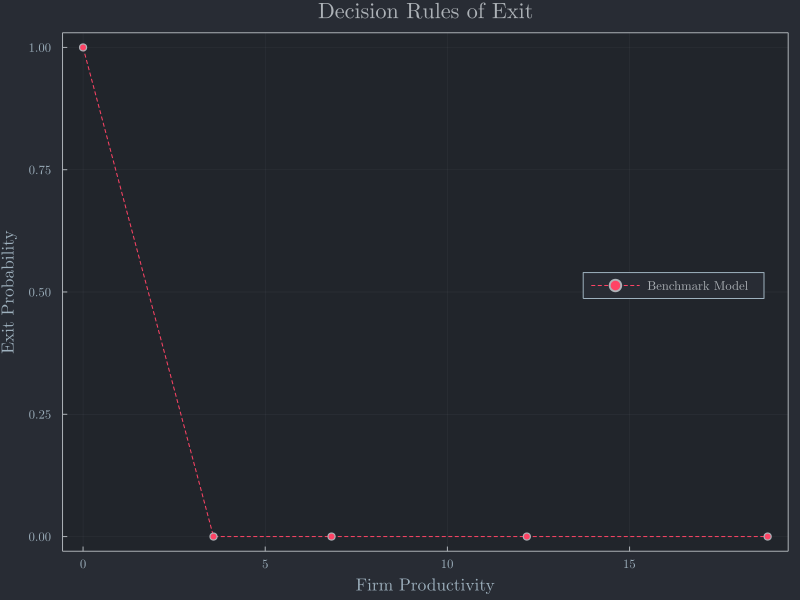

In [99]:
p1 = plot(prim.s_vals, res.x_opt, size=(800,600),
            title="Decision Rules of Exit", label="Benchmark Model",
            linestyle =:dash, markershape = :auto, legend = :right)
xlabel!("Firm Productivity")
ylabel!("Exit Probability")

#### Stationary Distributions

The distribution of firms in the market evolves acording to the following law of motion:
$$
\begin{aligned}
\mu^{\prime}\left(S_{0}\right)=& \int_{s^{\prime} \in S_{0}}\left\{\int_{s \in S}[1-X(s ; p)] d F\left(s^{\prime} \mid s\right) d \mu(s)\right\} d s^{\prime} \\
&+\int_{s^{\prime} \in S_{0}}\left\{\int_{s \in S}[1-X(s ; p)] d F\left(s^{\prime} \mid s\right) M \nu(d s)\right\} d s^{\prime}
\end{aligned}
$$

In parctical terms this implies that in $t+1$ the mass of $s_i$ firms present in the market is:

$$
\begin{align*}
\mu_{t+1}(s_i) &= \sum_{s_j \in S} (1-X(s_j))\mu_t(s_j)F(s_i\mid s_j) + \sum_{s_j \in S} (1-X(s_j))M\nu_t(s_j)F(s_i\mid s_j) \\&= \sum_{s_j \in S} (1-X(s_j))F(s_i\mid s_j)(\mu_t(s_j) + M\nu(s_j)) \quad \forall s_i \in S
\end{align*}
$$

We can define the following matrix:
$$B = \left(\begin{array}{ccc}
    (1 - X(s_1))F(s_1\mid s_1) & \ldots & (1 - X(s_n))F(s_1\mid s_n)\\
    \vdots & \ddots & \vdots\\
    (1 - X(s_1))F(s_n\mid s_1) & \ldots & (1 - X(s_n))F(s_n\mid s_n)
\end{array}\right)$$

We can re-write te above system of equations in matix form:
$$\mu_{t+1} = B(\mu_t + M \nu)$$

A stationary distribution is a fixed point of the system wich we can solve using matrix algebra:

$$
\begin{align*}
\mu^* = B(\mu^* + M \nu) &\quad \implies \quad \mu^* - B\mu^*= B M \nu\\
&\quad \implies \quad [I - B]\mu^* = B M \nu \\
&\quad \implies \quad \mu^*(M)= M [I - B]^{-1} B \nu 
\end{align*}
$$

We have now a closed form solution for the stationary distribution that only depends on the optimal decicion rules and the primitives of the model.

The following `Julia` function implements the stationary distribution.

In [100]:
function Tμ(prim::Primitives, x::Array{Float64}, M::Float64)
    @unpack ν, nS, trans_mat = prim
    # Calculate B Matrix
    B = repeat((1 .- x)', nS) .* trans_mat'
    return M* (I - B)^(-1) * B * ν
end

Tμ (generic function with 3 methods)

In [101]:
function labor_supply_demand(prim::Primitives, res::Results; M::Float64=res.M)
    @unpack c_e, ν = prim

    res.μ = Tμ(prim, res.x_opt, M)
    
    # Calculate optimal labor demand for each firm (for each productivity level)
    n_opt = prim.n_optim.(prim.s_vals, res.p)
    # Calculate profit for each firm (for each productivity level)
    prof =  prim.Π.( prim.s_vals, res.p, n_opt)
    # Calculate  mass of firms in the market (for each productivity level)
    mass = res.μ  + M *  prim.ν

    # Calculate Total labor demand
    tot_labor_demand = n_opt' * mass 

    # Calculate total profits 
    tot_profit = prof' * mass
    # Calculate total supply of labor
    tot_labor_supply = 1/prim.A - tot_profit

    return tot_labor_supply, tot_labor_demand

end

labor_supply_demand (generic function with 1 method)

In [102]:
M_range = range(prim.M_min, stop = 5, length=100)

L_S_D = map( x-> labor_supply_demand.(Ref(prim), Ref(res), M=x), M_range)
L_S_D = hcat(collect.(L_S_D)...)

2×100 Matrix{Float64}:
 192.357   192.048   191.74    …  162.712  162.404  162.095  161.786
  68.1538   70.9075   73.6612     332.508  335.262  338.015  340.769

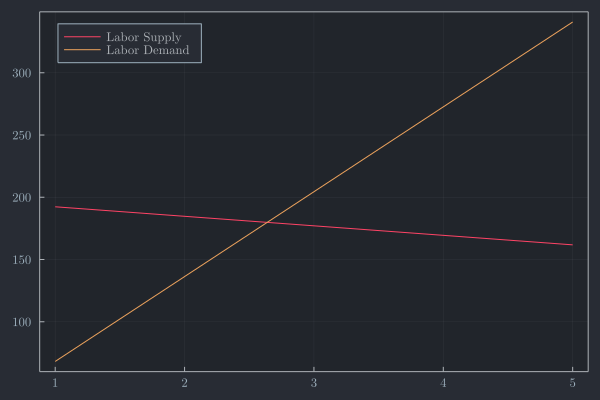

In [103]:
plot(M_range, L_S_D[1,:], c=1, label = "Labor Supply", legend=:topleft)
plot!(M_range, L_S_D[2,:], c=2, label = "Labor Demand")

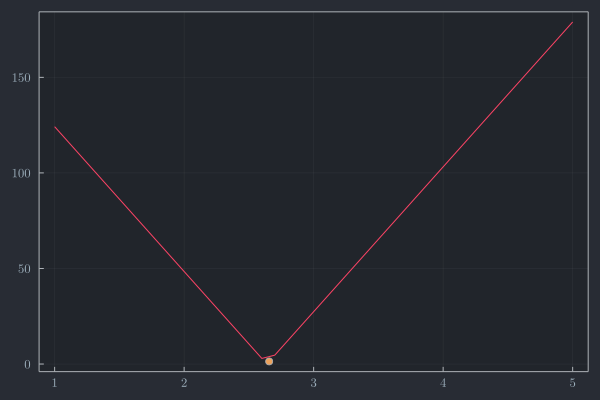

In [104]:
itp = LinearInterpolation(M_range, abs.(L_S_D[1,:] - L_S_D[2,:]))

opt = optimize( x -> abs(itp(x)), M_range[1], M_range[end] )

plot(1.0:0.1:5.0, itp(1.0:0.1:5.0), label="")
scatter!([opt.minimizer], [itp(opt.minimizer)], label="")

In [105]:
# Iterate until labor market clears
function Tμ_iterate_until_cleared(prim::Primitives, res::Results;  tol::Float64 = 1e-3, n_max::Int64 = 1000)
    @unpack Π, n_optim , s_vals, ν, A, M_min, M_max = prim
    
    θ = 0.5
    n = 0 #counter
    err = 100.0 #initialize error

    
    while  (abs(err) > tol) & (n < n_max)#begin iteration
        # Calculate optimal labor demand for a given mass of entrants

        tot_labor_supply, tot_labor_demand = labor_supply_demand(prim::Primitives, res::Results)

        # Labor MarketClearing condition
        LMC = tot_labor_demand - tot_labor_supply

        # adjust tuning parameter based on LMC
        if abs(LMC) > tol * 10000
            θ = 0.5
        elseif abs(LMC) > tol * 5000
            θ = 0.75
        elseif abs(LMC) > tol * 1000
            θ = 0.9
        else
            θ = 0.99
        end    

        if (n+1) % 10 == 0
            println(n+1, " iterations; LMC = ", LMC, ", M = ", res.M, ", M_min = ", M_min, ", M_max = ", M_max, ", θ = ", θ)
        end
        
        if abs( LMC ) < tol
            println("Labor Market Cleared in $(n+1) iterations, Mass of entrants = $(res.M)")
            break
        end
        # adjust price toward bounds according to tuning parameter
        if LMC > 0
            M_old = res.M
            res.M = θ*res.M + (1-θ)*M_min
            M_max = M_old
        else
            M_old = res.M
            res.M = θ*res.M + (1-θ)*M_max
            M_min = M_old
        end
        
        n += 1
    end

end # Tμ_iterate_until_cleared

Tμ_iterate_until_cleared(prim::Primitives, res::Results)

10 iterations; LMC = -0.13654294915281184, M = 2.6368393750000005, M_min = 2.6366875000000003, M_max = 2.6518750000000004, θ = 0.99
20 iterations; LMC = -0.027572053544474784, M = 2.638277050263448, M_min = 2.638139697235806, M_max = 2.6518750000000004, θ = 0.99
30 iterations; LMC = 0.00235386996976672, M = 2.6386718690793534, M_min = 2.638547649463206, M_max = 2.638673123822951, θ = 0.99
40 iterations; LMC = 0.0014535866211815573, M = 2.638659991457414, M_min = 2.638547649463206, M_max = 2.638661126225032, θ = 0.99
Labor Market Cleared in 46 iterations, Mass of entrants = 2.6386534172206972


## Part 2: Adding Random Disturbances to Action Values

Keep everything the same as in the first version except that now we introduce action-specific stochastic disturbances to the values associated with the discrete exit choice. The idea being that two agents with identical state variables may take different actions.

Denote by $V^{x'=0}$ and $V^{x'=1}$ the value associated with the two possible exit choices. Then the model can be re-written as:

 $$W(s;p) = \max_{x' \in \{0,1\}} V^{x'}(s;p)$$

Now consider an action specific shock $\varepsilon^{x'}$ to the value associated with the exit choice, the dynamic problem changes to:

$$W(\varepsilon, s;p) = \max_{x' \in \{0,1\}} V^{x'}(s;p) + \varepsilon^{x'}$$

Assume that $\varepsilon^{x'}$ is a random variable iid across time, actions and agents and follows a distribution $G(\varepsilon)$. Then the ex-ante value function is:

$$U(s ; p)=\int W(\epsilon, s ; p) d G(\varepsilon)$$

Now the value of starting in the market cahnges to:

$$V^{\left(x^{\prime}=0\right)}(s ; p)=\pi(s;p)+\beta \int_{s^{\prime}} U\left(s^{\prime} ; p\right) d F\left(d s^{\prime} \mid s\right)$$

In [106]:
function find_Vx(prim::Primitives, res::Results,  α::Float64 ; tol::Float64 = 1e-3, n_max::Int64 = 100)
    @unpack Π, n_optim , nS, s_vals, ν, A, M_min, M_max, β, trans_mat = prim
    # TODO: get nX from Primitives
    nX = 2
    
    # Initialize error and counter
    err = 100.0
    n = 0
    
    # Make initial guess of U(s;p)
    U₀ = zeros(nS)
    # Optimal labor demand and profits by productivity
    n_opt = n_optim.(s_vals, res.p)
    prof = Π.(s_vals, res.p, n_opt)
    
    # Initialize V_x
    V_x = ones(nS, nX) .* prof 
    σ_x = zeros(nS, nX)
    
    while (err > tol ) & (n < n_max)
        # Compute V_0(s;p), V_1(s;p) wont change 
        V_x[:, 1] = prof + β * (trans_mat * U₀)

        c = maximum(α * V_x, dims=2)  # Define normalization constant
        log_sum = c .+ log.( sum( exp.( α * V_x .- c), dims = 2 ) )

        # Find U₁
        U₁ = 1/α * ( 0.5772156649 .+ log_sum )

        err = maximum( abs.( U₁ - U₀ ) )
        # if n % 10 == 0 
        #     println("Iter $n err = $err")
        # end
        U₀ = copy(U₁)
        n += 1

        # We can also calculate and return σ at this point
        σ_1 = exp.(α*V_x[:, 2] .- log_sum)
        σ_0 = 1 .- σ_1
        σ_x = hcat( σ_0, σ_1 )

    end # end while
    # println("Iter $n err = $err")
    return V_x, σ_x
end # find_Vx

find_Vx (generic function with 1 method)

In [107]:
# Find equilibrium objects given a  variance indexer α for the shocks
function find_equilibrium(prim::Primitives, res::Results, α::Float64; tol::Float64 = 1e-3, n_max::Int64 = 100)
    
    @unpack Π, n_optim , nS, s_vals, ν, p_min, p_max, c_e = prim
    
    θ = 0.99
    n = 0
    
    println('='^150, "\n", "Solving for price such that entrants make 0 profits that TV1 Shocks α = $α", "\n", '='^150)
    while n < n_max
        V_x, σ_x = find_Vx(prim, res, α);


        # Calculate value of each firm
        n_opt  = n_optim.(s_vals, res.p)
        W_vals = Π.(s_vals, res.p, n_opt) + sum(σ_x .* V_x, dims=2)

        EC = sum(W_vals .* ν) - res.p * c_e
            

        # adjust tuning parameter based on EC
        if abs(EC) > tol * 10000
            θ = 0.5
        elseif abs(EC) > tol * 5000
            θ = 0.75
        elseif abs(EC) > tol * 1000
            θ = 0.9
        else
            θ = 0.99
        end    
        if n % 10 == 0
            println(n+1, " iterations; EC = ", EC, ", p = ", res.p, ", p_min = ", p_min, ", p_max = ", p_max, ", θ = ", θ)
        end
        if abs( EC ) < tol
            # println("Market Cleared in $(n+1) iterations.")
            break
        end

        # adjust price toward bounds according to tuning parameter
        if EC > 0
            p_old = res.p
            res.p = θ*res.p + (1-θ)*p_min
            p_max = p_old
        else
            p_old = res.p
            res.p = θ*res.p + (1-θ)*p_max
            p_min = p_old
        end
        n += 1
        res.x_opt = copy(σ_x[:,2])
    end # end while
    println("Price converged in $(n+1) iterations, p = $(res.p)")

    println('='^150, "\n", "Solving for optimal mass of entrants TV1 Shocks α = $α", "\n", '='^150)
    Tμ_iterate_until_cleared(prim, res)

end # find_equilibrium

find_equilibrium (generic function with 1 method)

### Solving TV1 Shocks $\alpha = 1$

In [108]:
find_equilibrium(prim, res_1, 1.0)

Solving for price such that entrants make 0 profits that TV1 Shocks α = 1.0
1 iterations; EC = 247.81388059865174, p = 1.505, p_min = 0.01, p_max = 3.0, θ = 0.5
11 iterations; EC = -0.5334246469716204, p = 0.7056779369583117, p_min = 0.7051544817760724, p_max = 0.7575, θ = 0.99
21 iterations; EC = -0.19366910617534838, p = 0.7106330550951208, p_min = 0.7101596516112331, p_max = 0.7575, θ = 0.99
31 iterations; EC = 0.0011206600886470852, p = 0.7133581393513231, p_min = 0.7129300017262482, p_max = 0.7133624639737985, θ = 0.99
Price converged in 32 iterations, p = 0.7133538579750723
Solving for optimal mass of entrants TV1 Shocks α = 1.0
10 iterations; LMC = 0.07972967904663619, M = 2.7573764900249995, M_min = 2.754975, M_max = 2.7574007474999997, θ = 0.99
20 iterations; LMC = 0.06306767922583845, M = 2.7571468645319213, M_min = 2.754975, M_max = 2.7571688025574965, θ = 0.99
30 iterations; LMC = 0.047998865254186285, M = 2.756939195352016, M_min = 2.754975, M_max = 2.756959035709107, θ = 

### Solving TV1 Shocks $\alpha = 2$

In [109]:
find_equilibrium(prim, res_2, 2.0)

Solving for price such that entrants make 0 profits that TV1 Shocks α = 2.0
1 iterations; EC = 246.6594672846812, p = 1.505, p_min = 0.01, p_max = 3.0, θ = 0.5
11 iterations; EC = -0.6584364778959633, p = 0.7146718487258775, p_min = 0.71423924113725, p_max = 0.7575, θ = 0.99
21 iterations; EC = -0.4033747092282618, p = 0.718766987681918, p_min = 0.7183757451332505, p_max = 0.7575, θ = 0.99
31 iterations; EC = -0.16028079065290868, p = 0.7224705579484314, p_min = 0.7221167252004358, p_max = 0.7575, θ = 0.99
41 iterations; EC = 0.0023537257345451756, p = 0.724840475658694, p_min = 0.7245204756638556, p_max = 0.7248437079818741, θ = 0.99
Price converged in 48 iterations, p = 0.724818736570375
Solving for optimal mass of entrants TV1 Shocks α = 2.0
10 iterations; LMC = 1.3279375492330985, M = 3.0531440999999995, M_min = 3.0, M_max = 3.0590489999999995, θ = 0.9
20 iterations; LMC = 0.7047370944839315, M = 3.0436932467567948, M_min = 3.0, M_max = 3.0441345926836307, θ = 0.99
30 iterations; L

### Solving TV1 Shocks $\alpha = 3$

In [110]:
find_equilibrium(prim, res_3, 3.0)

Solving for price such that entrants make 0 profits that TV1 Shocks α = 3.0
1 iterations; EC = 246.27466284669094, p = 1.505, p_min = 0.01, p_max = 3.0, θ = 0.5
11 iterations; EC = -0.7947044012085271, p = 0.7146718487258775, p_min = 0.71423924113725, p_max = 0.7575, θ = 0.99
21 iterations; EC = -0.5585122517245869, p = 0.718766987681918, p_min = 0.7183757451332505, p_max = 0.7575, θ = 0.99
31 iterations; EC = -0.3323038897437969, p = 0.7224705579484314, p_min = 0.7221167252004358, p_max = 0.7575, θ = 0.99
41 iterations; EC = -0.11686751867362188, p = 0.7258200005110017, p_min = 0.7255000005161634, p_max = 0.7575, θ = 0.99
51 iterations; EC = 0.005711458470308628, p = 0.7276620379644602, p_min = 0.7273726357051254, p_max = 0.727664961219605, θ = 0.99
61 iterations; EC = 0.003847925948233133, p = 0.7276343659209348, p_min = 0.7273726357051254, p_max = 0.7276370096604884, θ = 0.99
71 iterations; EC = 0.0021631594336737336, p = 0.7276093398207916, p_min = 0.7273726357051254, p_max = 0.727

## Make final Plots and Tables

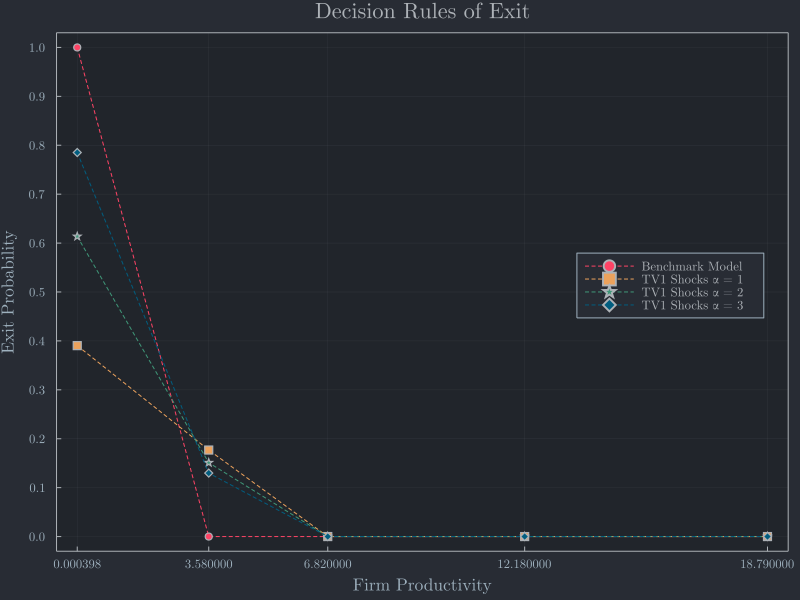

In [112]:
results = [res_1, res_2, res_3]

p2 = plot(prim.s_vals, res.x_opt, size=(800,600),
            title="Decision Rules of Exit", label="Benchmark Model",
            linestyle =:dash, markershape = :auto, legend = :right)
xticks!(prim.s_vals)
yticks!(0:0.1:1)
xlabel!("Firm Productivity")
ylabel!("Exit Probability")

for i in 1:length(results)
    plot!(prim.s_vals, results[i].x_opt, size=(800,600),
            title="Decision Rules of Exit", label="TV1 Shocks α = $i ",
            linestyle =:dash, markershape = :auto)
end

p2

In [172]:
results = [res, res_1, res_2, res_3]

# Get vatiables from tables

using Latexify, DataFrames

n_opt = [prim.n_optim.(prim.s_vals, r.p) for r in results]
n_incumbents = [ n_opt[i]' * results[i].μ for i in 1:length(results) ]
n_entrants = [ n_opt[i]' * prim.ν * results[i].M for i in 1:length(results) ]
n_total = [n_incumbents[i] + n_entrants[i] for i in 1:length(results) ]
fraction_labor_entrants = [n_entrants[i] ./ n_total[i] for i in 1:length(results) ]

df = DataFrame(["Price Level" => [r.p for r in results]
                "Mass of Incumbents" => [sum(r.μ) for r in results]
                "Mass of Entrants" => [sum(r.M .* prim.ν) for r in results]
                "Mass of Exits" => [sum(r.μ .* r.x_opt) for r in results]
                "Aggregate Labor" => n_total
                "Labor of Incumbents" => n_incumbents
                "Labor of Entrants" => n_entrants
                "Fraction of Labor Entrants" => fraction_labor_entrants]
                )
                df = round.(df, digits=3)
                colnames = names(df)
                df[!, :id] = ["Standard", "TV1 Shock α = 1", "TV1 Shock α = 2", "TV1 Shock α = 3"]
df = unstack(stack(df, colnames), :variable, :id, :value)

,variable,Standard,TV1 Shock α = 1,TV1 Shock α = 2,TV1 Shock α = 3
,String,Float64?,Float64?,Float64?,Float64?
1,Price Level,0.739,0.713,0.725,0.728
2,Mass of Incumbents,8.321,10.336,8.829,8.207
3,Mass of Entrants,2.639,2.756,3.033,3.218
4,Mass of Exits,1.662,2.132,2.132,2.09
5,Aggregate Labor,179.834,187.775,183.024,181.198
6,Labor of Incumbents,142.627,152.541,142.497,137.744
7,Labor of Entrants,37.207,35.234,40.527,43.455
8,Fraction of Labor Entrants,0.207,0.188,0.221,0.24
